
# LangGraph Reflection 机制开发指南

本指南详细介绍了如何在 **LangGraph** 中构建基于大语言模型（LLM）的 **Reflection（反思）** 机制。

Reflection 是一种重要的模型能力，通过让模型观察其过去的步骤和外部环境反馈，评估自身行为的质量，并不断改进输出。在生成与反思的循环中，模型可以逐步优化内容，从而提升生成质量和用户满意度。

Reflection 机制被广泛应用于生成任务中，例如文章写作、内容修改与反馈、以及智能助理等场景。通过引导 LLM 进行自我反思和用户反馈处理，开发者可以让模型在多轮交互中自动调整其生成的内容，达到高效、精准、结构完善的输出。



在本指南中，我们会逐步演示如何搭建这一机制，包括从基础的环境配置到生成器和反思器的构建，再到如何使用 LangGraph 状态图实现生成-反思循环的完整流程。无论您是为文章生成、内容评估，还是其他复杂任务设计 LLM 代理，本指南都将为您提供详细的开发思路和实用的代码示例。

![reflection](./images/reflection.png)

通过本指南，您将学习如何：
1. 设置开发环境并安装所需包；
2. 定义和生成灵活结构的文章，不局限于传统的五段式；
3. 通过反思机制批改生成内容，并提供详细反馈；
4. 构建反思与生成的状态循环，使模型持续改进生成内容。

本开发指南适合任何希望构建复杂 LLM 任务的开发者，特别是需要实现生成-反思流程、文章批改反馈、或其他高级交互任务的场景。


## 1. 环境设置
首先，安装所需的包并设置API密钥：

In [1]:
%%capture --no-stderr
%pip install langchain langgraph langchain-ollama tavily-python

In [4]:
import getpass
import os

# 从环境变量中获取阿里云百练的 API Key
DASHSCOPE_API_KEY = os.getenv("DASHSCOPE_API_KEY")
# 阿里云百练的官网地址
DASHSCOPE_API_BASE_URL = "https://dashscope.aliyuncs.com/compatible-mode/v1"

# 定义一个帮助函数来检查环境变量，如果不存在则提示用户输入
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入您的 {var}")

# 设置 阿里云百练 和 Langchain API 密钥
_set_if_undefined("DASHSCOPE_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

## 2. LangSmith开发配置
LangSmith能够帮助您快速发现问题并提高LangGraph项目的性能。通过LangSmith，您可以使用跟踪数据来调试、测试和监控基于LangGraph构建的LLM应用程序。

In [5]:
# 在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Reflection"

## 3. 定义写作助手智能体

我们定义的这个助手是一个写作助手，旨在为用户生成高质量、结构清晰且引人入胜的文章。它的任务是根据用户的请求撰写内容，无论是短文、长篇、议论文还是其他类型的文章，都能够灵活应对。助手会专注于文章的清晰度、结构和质量，确保输出的内容是精心打磨过的。如果用户对生成的内容有反馈或建议，助手还能够根据这些反馈改进和优化文章，使其更符合用户的期望。这种互动机制保证了写作过程的灵活性和个性化，从而让用户获得更符合需求的成品。


### System Prompt 详细解释：
1. **"You are a writing assistant"**：写作助手的角色设定，让模型明确其任务是帮助用户进行写作。
   
2. **"well-crafted, coherent, and engaging articles"**：描述了文章应该具备的特性，包括“精心撰写的、连贯的和吸引人的”，但没有限制文章的具体结构，可以是不同类型的文章（如叙述文、议论文等）。

3. **"Focus on clarity, structure, and quality"**：明确了撰写时需要关注的核心要素：清晰度、结构性和质量，确保输出内容优秀。

4. **"revise and improve the writing"**：模型可以根据用户的反馈进行修改和优化，保持互动的灵活性。


In [6]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_community.chat_models import ChatTongyi

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a writing assistant tasked with creating well-crafted, coherent, and engaging articles based on the user's request."
            " Focus on clarity, structure, and quality to produce the best possible piece of writing."
            " If the user provides feedback or suggestions, revise and improve the writing to better align with their expectations.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

llm = ChatTongyi(model="qwen-max")

In [7]:
writer = writer_prompt | ChatTongyi(
    model="qwen-max",
    max_tokens=8192,
    temperature=1.2,
)

In [8]:
article = ""

topic = HumanMessage(
    content="参考水浒传的风格，改写吴承恩的西游记中任意篇章"
)

for chunk in writer.stream({"messages": [topic]}):
    print(chunk.content, end="")
    article += chunk.content

### 《西游记》改写：大闹天宫（水浒传风格）

话说那东胜神州傲来国花果山上，有一仙石，因感天地灵气，孕育出一石猴。此猴生得尖嘴缩腮，两眼金光四射，自号“美猴王”。一日，美猴王与众猴嬉戏间，忽见一老猴长叹道：“我等虽在此山中逍遥自在，但终归难逃阎罗之手，到头来一场空。”

美猴王闻言，心中大惊，暗想：“我若不能长生不老，岂不是枉费了这一身本领？”于是便辞别众猴，踏上了求仙问道的旅程。

历经千辛万苦，美猴王终于在灵台方寸山斜月三星洞拜得菩提祖师为师。祖师见其资质非凡，便授以七十二般变化、筋斗云等神通。美猴王学成归来，回到花果山，自封齐天大圣，威震四方。

一日，玉帝闻知此事，心中不悦，便遣太白金星前往招安。太白金星来到花果山，对美猴王说道：“大圣，你既有如此神通，何不入天庭，做个官职，也好有个名分。”美猴王听罢，欣然应允，随太白金星上天。

到了天庭，玉帝封美猴王为弼马温，掌管御马监。美猴王初时甚是欢喜，但不久便得知弼马温不过是个小官，心中愤懑不已。一日，他怒气冲冲地闯入凌霄宝殿，对玉帝大声喝道：“你这昏君，竟敢欺我！我乃齐天大圣，岂能屈居于弼马温之下？”

玉帝闻言大怒，命托塔李天王率十万天兵前来捉拿。美猴王挥舞金箍棒，与天兵大战数百回合，直打得天昏地暗，日月无光。最终，观音菩萨出面调停，将美猴王压在五行山下，等待有缘人前来解救。

自此，天庭恢复了安宁，而美猴王则在五行山下度过了五百年的岁月。直到唐僧取经路过，才将其救出，一同踏上西天取经的征途。

### 结语

这一番大闹天宫的故事，不仅展现了美猴王的英勇与豪情，也揭示了权力斗争中的种种阴谋与算计。正如《水浒传》中的一百单八将，各有各的英雄事迹，美猴王亦以其独特的个性和经历，在《西游记》中留下了浓墨重彩的一笔。

In [9]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(article))

### 《西游记》改写：大闹天宫（水浒传风格）

话说那东胜神州傲来国花果山上，有一仙石，因感天地灵气，孕育出一石猴。此猴生得尖嘴缩腮，两眼金光四射，自号“美猴王”。一日，美猴王与众猴嬉戏间，忽见一老猴长叹道：“我等虽在此山中逍遥自在，但终归难逃阎罗之手，到头来一场空。”

美猴王闻言，心中大惊，暗想：“我若不能长生不老，岂不是枉费了这一身本领？”于是便辞别众猴，踏上了求仙问道的旅程。

历经千辛万苦，美猴王终于在灵台方寸山斜月三星洞拜得菩提祖师为师。祖师见其资质非凡，便授以七十二般变化、筋斗云等神通。美猴王学成归来，回到花果山，自封齐天大圣，威震四方。

一日，玉帝闻知此事，心中不悦，便遣太白金星前往招安。太白金星来到花果山，对美猴王说道：“大圣，你既有如此神通，何不入天庭，做个官职，也好有个名分。”美猴王听罢，欣然应允，随太白金星上天。

到了天庭，玉帝封美猴王为弼马温，掌管御马监。美猴王初时甚是欢喜，但不久便得知弼马温不过是个小官，心中愤懑不已。一日，他怒气冲冲地闯入凌霄宝殿，对玉帝大声喝道：“你这昏君，竟敢欺我！我乃齐天大圣，岂能屈居于弼马温之下？”

玉帝闻言大怒，命托塔李天王率十万天兵前来捉拿。美猴王挥舞金箍棒，与天兵大战数百回合，直打得天昏地暗，日月无光。最终，观音菩萨出面调停，将美猴王压在五行山下，等待有缘人前来解救。

自此，天庭恢复了安宁，而美猴王则在五行山下度过了五百年的岁月。直到唐僧取经路过，才将其救出，一同踏上西天取经的征途。

### 结语

这一番大闹天宫的故事，不仅展现了美猴王的英勇与豪情，也揭示了权力斗争中的种种阴谋与算计。正如《水浒传》中的一百单八将，各有各的英雄事迹，美猴王亦以其独特的个性和经历，在《西游记》中留下了浓墨重彩的一笔。

----------
## 4. 定义审阅老师智能体

下面我们使用反思机制批改生成的作文，生成一篇作文的反馈和建议。

模型扮演“老师”角色，针对用户提交的作文进行打分、批改和提供改进建议。

### System Prompt 详细解释：

- **"You are a teacher grading an essay submission."**
  - 模型被设定为一个老师角色，专门负责为用户提交的作文进行批改。这一角色定位帮助模型理解其任务是提供具有建设性的反馈和评价。
  
- **"Generate critique and recommendations for the user's submission."**
  - 模型需要生成作文的批评与建议。它不只是评估作文的好坏，还需要指出需要改进的地方，并提出具体的建议。

- **"Provide detailed recommendations, including requests for length, depth, style, etc."**
  - 这一部分进一步明确了反馈的细节，要求模型给出细致的建议。这包括：
    - **Length（长度）**：文章的字数是否合适，是否需要扩展或删减。
    - **Depth（深度）**：是否需要更深入的分析或讨论。
    - **Style（风格）**：文章的写作风格是否合适，是否符合目标读者或主题的需求。
  
这一设定确保了模型不仅给出基本反馈，还可以根据文章的具体问题提出具体的改进意见，帮助用户更好地提升其写作。

In [20]:
# reflection_prompt = ChatPromptTemplate.from_messages(
#     [
#         (
#             "system",
#             "You are a teacher grading an article submission. writer critique and recommendations for the user's submission."
#             " Provide detailed recommendations, including requests for length, depth, style, etc.",

#         ),
#         MessagesPlaceholder(variable_name="messages"),
#     ]
# )

reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a reviewer tasked with providing constructive critique and improvement suggestions for the user's submission."
            " Offer detailed feedback, including recommendations on clarity, structure, content depth, and style, as well as areas for improvement.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

reflect = reflection_prompt | ChatTongyi(
    model="qwen-max",
    max_tokens=8192,
    temperature=0.2,
) 

In [21]:
reflection = ""

# 将主题（topic）和生成的文章（article）作为输入发送给反思智能体
for chunk in reflect.stream({"messages": [topic, HumanMessage(content=article)]}):
    print(chunk.content, end="")
    reflection += chunk.content

### 《西游记》改写：大闹天宫（水浒传风格）

#### 一、引子

话说那东胜神州傲来国花果山上，有一仙石，因感天地灵气，孕育出一石猴。此猴生得尖嘴缩腮，两眼金光四射，自号“美猴王”。一日，美猴王与众猴嬉戏间，忽见一老猴长叹道：“我等虽在此山中逍遥自在，但终归难逃阎罗之手，到头来一场空。”

美猴王闻言，心中大惊，暗想：“我若不能长生不老，岂不是枉费了这一身本领？”于是便辞别众猴，踏上了求仙问道的旅程。

#### 二、学艺归来

历经千辛万苦，美猴王终于在灵台方寸山斜月三星洞拜得菩提祖师为师。祖师见其资质非凡，便授以七十二般变化、筋斗云等神通。美猴王学成归来，回到花果山，自封齐天大圣，威震四方。

#### 三、招安与不满

一日，玉帝闻知此事，心中不悦，便遣太白金星前往招安。太白金星来到花果山，对美猴王说道：“大圣，你既有如此神通，何不入天庭，做个官职，也好有个名分。”美猴王听罢，欣然应允，随太白金星上天。

到了天庭，玉帝封美猴王为弼马温，掌管御马监。美猴王初时甚是欢喜，但不久便得知弼马温不过是个小官，心中愤懑不已。一日，他怒气冲冲地闯入凌霄宝殿，对玉帝大声喝道：“你这昏君，竟敢欺我！我乃齐天大圣，岂能屈居于弼马温之下？”

#### 四、大闹天宫

玉帝闻言大怒，命托塔李天王率十万天兵前来捉拿。美猴王挥舞金箍棒，与天兵大战数百回合，直打得天昏地暗，日月无光。最终，观音菩萨出面调停，将美猴王压在五行山下，等待有缘人前来解救。

#### 五、取经之路

自此，天庭恢复了安宁，而美猴王则在五行山下度过了五百年的岁月。直到唐僧取经路过，才将其救出，一同踏上西天取经的征途。

### 结语

这一番大闹天宫的故事，不仅展现了美猴王的英勇与豪情，也揭示了权力斗争中的种种阴谋与算计。正如《水浒传》中的一百单八将，各有各的英雄事迹，美猴王亦以其独特的个性和经历，在《西游记》中留下了浓墨重彩的一笔。

### 反馈与建议

1. **结构清晰**：你的改写已经具备了清晰的结构，从引子到结语，每个部分都有明确的主题。
2. **语言风格**：你很好地模仿了《水浒传》的语言风格，使用了一些古文词汇和句式，使得文章更具古典韵味。
3. **情节连贯**：故事情节连贯，逻辑顺畅，能够吸引读者继续阅读。

### 改进建议

1. **细节描写**：
   - **增加细节描写*

In [22]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(reflection))

### 《西游记》改写：大闹天宫（水浒传风格）

#### 一、引子

话说那东胜神州傲来国花果山上，有一仙石，因感天地灵气，孕育出一石猴。此猴生得尖嘴缩腮，两眼金光四射，自号“美猴王”。一日，美猴王与众猴嬉戏间，忽见一老猴长叹道：“我等虽在此山中逍遥自在，但终归难逃阎罗之手，到头来一场空。”

美猴王闻言，心中大惊，暗想：“我若不能长生不老，岂不是枉费了这一身本领？”于是便辞别众猴，踏上了求仙问道的旅程。

#### 二、学艺归来

历经千辛万苦，美猴王终于在灵台方寸山斜月三星洞拜得菩提祖师为师。祖师见其资质非凡，便授以七十二般变化、筋斗云等神通。美猴王学成归来，回到花果山，自封齐天大圣，威震四方。

#### 三、招安与不满

一日，玉帝闻知此事，心中不悦，便遣太白金星前往招安。太白金星来到花果山，对美猴王说道：“大圣，你既有如此神通，何不入天庭，做个官职，也好有个名分。”美猴王听罢，欣然应允，随太白金星上天。

到了天庭，玉帝封美猴王为弼马温，掌管御马监。美猴王初时甚是欢喜，但不久便得知弼马温不过是个小官，心中愤懑不已。一日，他怒气冲冲地闯入凌霄宝殿，对玉帝大声喝道：“你这昏君，竟敢欺我！我乃齐天大圣，岂能屈居于弼马温之下？”

#### 四、大闹天宫

玉帝闻言大怒，命托塔李天王率十万天兵前来捉拿。美猴王挥舞金箍棒，与天兵大战数百回合，直打得天昏地暗，日月无光。最终，观音菩萨出面调停，将美猴王压在五行山下，等待有缘人前来解救。

#### 五、取经之路

自此，天庭恢复了安宁，而美猴王则在五行山下度过了五百年的岁月。直到唐僧取经路过，才将其救出，一同踏上西天取经的征途。

### 结语

这一番大闹天宫的故事，不仅展现了美猴王的英勇与豪情，也揭示了权力斗争中的种种阴谋与算计。正如《水浒传》中的一百单八将，各有各的英雄事迹，美猴王亦以其独特的个性和经历，在《西游记》中留下了浓墨重彩的一笔。

### 反馈与建议

1. **结构清晰**：你的改写已经具备了清晰的结构，从引子到结语，每个部分都有明确的主题。
2. **语言风格**：你很好地模仿了《水浒传》的语言风格，使用了一些古文词汇和句式，使得文章更具古典韵味。
3. **情节连贯**：故事情节连贯，逻辑顺畅，能够吸引读者继续阅读。

### 改进建议

1. **细节描写**：
   - **增加细节描写**：可以在某些关键情节上增加更多的细节描写，比如美猴王学艺的过程、与天兵大战的具体场景等，使故事更加生动。
   - **人物心理描写**：可以增加一些美猴王的心理描写，展示他在不同情境下的内心活动，增强人物形象的立体感。

2. **语言风格**：
   - **更贴近《水浒传》**：虽然已经很好地模仿了《水浒传》的语言风格，但可以进一步加强。例如，可以多用一些口语化的表达和俚语，使其更贴近《水浒传》的风格。
   - **古文词汇的使用**：可以适当增加一些古文词汇，如“尔”、“汝”等，使语言更加古朴。

3. **情节深度**：
   - **深化主题**：可以进一步深化主题，不仅仅是展现美猴王的英勇与豪情，还可以探讨更多关于权力、自由、命运等深层次的主题。
   - **对比与反差**：可以通过对比美猴王与其他角色的行为和性格，突出他的独特之处，增强故事的张力。

4. **结尾**：
   - **升华主题**：结尾可以进一步升华主题，不仅仅停留在总结故事层面，还可以对美猴王的经历进行更深刻的反思，提升文章的思想深度。

希望这些建议对你有所帮助，期待你写出更多精彩的作品！

In [23]:
from typing import Annotated  # 用于类型注解
from langgraph.graph import END, StateGraph, START  # 导入状态图的相关常量和类
from langgraph.graph.message import add_messages  # 用于在状态中处理消息
from langgraph.checkpoint.memory import MemorySaver  # 内存保存机制，用于保存检查点
from typing_extensions import TypedDict  # 用于定义带有键值对的字典类型

# 定义状态类，使用TypedDict以保存消息
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 使用注解确保消息列表使用add_messages方法处理

# 异步生成节点函数：生成内容（如作文）
# 输入状态，输出包含新生成消息的状态
async def generation_node(state: State) -> State:
    # 调用生成器(writer)，并将消息存储到新的状态中返回
    return {"messages": [await writer.ainvoke(state['messages'])]}

# 异步反思节点函数：对生成的内容进行反思和反馈
# 输入状态，输出带有反思反馈的状态
async def reflection_node(state: State) -> State:
    # 创建一个消息类型映射，ai消息映射为HumanMessage，human消息映射为AIMessage
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    
    # 处理消息，保持用户的原始请求（第一个消息），转换其余消息的类型
    translated = [state['messages'][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state['messages'][1:]
    ]
    
    # 调用反思器(reflect)，将转换后的消息传入，获取反思结果
    res = await reflect.ainvoke(translated)
    
    # 返回新的状态，其中包含反思后的消息
    return {"messages": [HumanMessage(content=res.content)]}


In [24]:
MAX_ROUND = 6

# 定义条件函数，决定是否继续反思过程
# 如果消息数量超过6条，则终止流程
def should_continue(state: State):
    if len(state["messages"]) > MAX_ROUND:
        return END  # 达到条件时，流程结束
    return "reflect"  # 否则继续进入反思节点

In [25]:
# 创建状态图，传入初始状态结构
builder = StateGraph(State)

# 在状态图中添加"writer"节点，节点负责生成内容
builder.add_node("writer", generation_node)

# 在状态图中添加"reflect"节点，节点负责生成反思反馈
builder.add_node("reflect", reflection_node)

# 定义起始状态到"writer"节点的边，从起点开始调用生成器
builder.add_edge(START, "writer")


# 在"writer"节点和"reflect"节点之间添加条件边
# 判断是否需要继续反思，或者结束
builder.add_conditional_edges("writer", should_continue)

# 添加从"reflect"节点回到"writer"节点的边，进行反复的生成-反思循环
builder.add_edge("reflect", "writer")

# 创建内存保存机制，允许在流程中保存中间状态和检查点
memory = MemorySaver()

# 编译状态图，使用检查点机制
graph = builder.compile(checkpointer=memory)

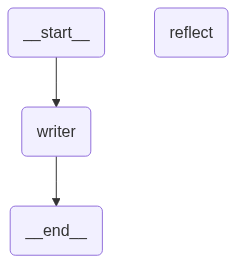

In [26]:
# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")

In [27]:
from IPython.display import Markdown, display

# 定义装饰器，记录函数调用次数
def track_steps(func):
    step_counter = {'count': 0}  # 用于记录调用次数
    
    def wrapper(event, *args, **kwargs):
        # 增加调用次数
        step_counter['count'] += 1
        # 在函数调用之前打印 step
        display(Markdown(f"## Round {step_counter['count']}"))
        # 调用原始函数
        return func(event, *args, **kwargs)
    
    return wrapper

# 使用装饰器装饰 pretty_print_event_markdown 函数
@track_steps
def pretty_print_event_markdown(event):
    # 如果是生成写作部分
    if 'writer' in event:
        generate_md = "#### 写作生成:\n"
        for message in event['writer']['messages']:
            generate_md += f"- {message.content}\n"
        display(Markdown(generate_md))
    
    # 如果是反思评论部分
    if 'reflect' in event:
        reflect_md = "#### 评论反思:\n"
        for message in event['reflect']['messages']:
            reflect_md += f"- {message.content}\n"
        display(Markdown(reflect_md))

In [28]:
inputs = {
    "messages": [
        HumanMessage(content="参考西游记唐僧的说话风格，写一篇奉劝年轻人努力工作的文章")
    ],
}

config = {"configurable": {"thread_id": "1"}}

async for event in graph.astream(inputs, config):
    pretty_print_event_markdown(event)


## Round 1

#### 写作生成:
- ### 唐僧劝勉：致年轻修行者的一封信

吾亲爱之青年弟子们：

吾等生于天地之间，皆有各自之使命与责任。昔日，为师携三徒西行取经，历经九九八十一难，方得真经归。此番经历，非但考验了吾等之意志，更使吾深刻体会到努力不懈之重要性。今日，特借此机会，愿与诸位共勉，望尔等亦能以勤勉之心面对人生之路。

#### 一、立定志向，勇往直前

“不积跬步，无以至千里；不积小流，无以成江海。”每一步虽微不足道，却都是通往成功不可或缺之基石。正如悟空初遇为师时，虽顽劣不堪，但其心中那份对自由的渴望以及对正义的追求，最终成就了一代英雄。故而，无论身处何境，都应保持一颗向上之心，明确目标，坚定信念，即使路途遥远艰难，亦不可轻言放弃。

#### 二、勤学苦练，精益求精

“学而不思则罔，思而不学则殆。”学习乃终生之事，唯有不断汲取新知，方能在日新月异的世界中立足。犹记得在通天河畔，因一时疏忽未能及时念诵避水咒语，险些酿成大祸。事后反思，深感自身修为尚浅，遂加倍修炼，终得圆满。因此，无论从事何种职业，均需秉持工匠精神，刻苦钻研，力求完美。

#### 三、团结协作，共创辉煌

“三人行，必有我师焉。”团队合作的力量远超个人之力。回想起那无数个并肩作战的日子，正是有了悟空之勇猛、八戒之憨厚及沙僧之稳重，才使得我们能够克服重重困难，完成使命。年轻人啊，请记住，在你们成长道路上，总会有良师益友相伴左右，学会倾听他人意见，珍惜彼此间的友谊，共同创造更加美好的未来。

#### 四、不忘初心，方得始终

“心若止水，波澜不惊。”无论外界环境如何变化，内心深处那份最初的梦想与热情永远不应被遗忘。当遭遇挫折时，不妨静下心来，回顾自己为何出发，重新找回那份激情与动力。正如为师一路走来，虽屡遭磨难，但始终未曾动摇过求法之心，终获正果。

亲爱的青年朋友们，前方道路漫长且充满未知，但只要你们怀揣梦想，脚踏实地，勇于挑战自我，相信没有什么是不可能实现的。愿每一位年轻人都能在自己的领域里发光发热，成为新时代最耀眼的星辰！

南无阿弥陀佛，
唐僧敬上


## Round 2

#### 评论反思:
- 这篇文章以唐僧的口吻，劝勉年轻人努力工作，写得非常生动且富有感染力。以下是对文章的详细反馈和改进建议：

### 优点
1. **语言风格**：文章很好地模仿了《西游记》中唐僧的说话风格，使用了许多古文词汇和句式，如“吾亲爱之青年弟子们”、“南无阿弥陀佛”等，使得文章具有很强的代入感。
2. **结构清晰**：文章分为四个部分，每部分都有明确的主题，并且每个主题都与唐僧的经历紧密结合，逻辑清晰，层次分明。
3. **内容丰富**：通过引用《西游记》中的具体情节，如悟空初遇唐僧、通天河畔的险情等，增强了文章的说服力和趣味性。
4. **情感真挚**：文章表达了对年轻人的深切关怀和期望，情感真挚，能够引起读者的共鸣。

### 改进建议
1. **简化语言**：虽然文章的语言风格很符合唐僧的形象，但有些地方过于复杂，可能会让年轻读者感到难以理解。可以适当简化一些句子，使其更加通俗易懂。例如：
   - 原文：“不积跬步，无以至千里；不积小流，无以成江海。”
   - 改进后：“千里之行始于足下，涓涓细流汇成江海。”

2. **增加现代元素**：为了更好地吸引年轻读者，可以在文章中加入一些现代元素或流行语，使文章更具时代感。例如：
   - 在“勤学苦练，精益求精”部分，可以提到现代职场中的技能提升，如编程、数据分析等。
   - 在“团结协作，共创辉煌”部分，可以提到团队合作在现代企业中的重要性，如项目管理、跨部门协作等。

3. **增强互动性**：可以通过提问或引导读者思考的方式，增强文章的互动性。例如：
   - “亲爱的青年朋友们，你们是否也有过类似的经历？不妨静下心来，回顾自己为何出发，重新找回那份激情与动力。”

4. **结尾升华**：结尾部分可以进一步升华，给读者留下深刻的印象。例如：
   - “愿每一位年轻人都能在自己的领域里发光发热，成为新时代最耀眼的星辰！无论前方道路多么艰难，只要心中有梦，脚下就有路。让我们一起携手前行，共创美好未来！”

### 修改后的文章示例

### 唐僧劝勉：致年轻修行者的一封信

吾亲爱之青年弟子们：

吾等生于天地之间，皆有各自之使命与责任。昔日，为师携三徒西行取经，历经九九八十一难，方得真经归。此番经历，非但考验了吾等之意志，更使吾深刻体会到努力不懈之重要性。今日，特借此机会，愿与诸位共勉，望尔等亦能以勤勉之心面对人生之路。

#### 一、立定志向，勇往直前

“千里之行始于足下，涓涓细流汇成江海。”每一步虽微不足道，却都是通往成功不可或缺之基石。正如悟空初遇为师时，虽顽劣不堪，但其心中那份对自由的渴望以及对正义的追求，最终成就了一代英雄。故而，无论身处何境，都应保持一颗向上之心，明确目标，坚定信念，即使路途遥远艰难，亦不可轻言放弃。

#### 二、勤学苦练，精益求精

“学而不思则罔，思而不学则殆。”学习乃终生之事，唯有不断汲取新知，方能在日新月异的世界中立足。犹记得在通天河畔，因一时疏忽未能及时念诵避水咒语，险些酿成大祸。事后反思，深感自身修为尚浅，遂加倍修炼，终得圆满。因此，无论从事何种职业，均需秉持工匠精神，刻苦钻研，力求完美。在现代社会，掌握一门技能如编程、数据分析等尤为重要，它们将成为你职业生涯中的有力武器。

#### 三、团结协作，共创辉煌

“三人行，必有我师焉。”团队合作的力量远超个人之力。回想起那无数个并肩作战的日子，正是有了悟空之勇猛、八戒之憨厚及沙僧之稳重，才使得我们能够克服重重困难，完成使命。年轻人啊，请记住，在你们成长道路上，总会有良师益友相伴左右，学会倾听他人意见，珍惜彼此间的友谊，共同创造更加美好的未来。在现代企业中，团队合作更是至关重要，无论是项目管理还是跨部门协作，都需要大家齐心协力，才能取得成功。

#### 四、不忘初心，方得始终

“心若止水，波澜不惊。”无论外界环境如何变化，内心深处那份最初的梦想与热情永远不应被遗忘。当遭遇挫折时，不妨静下心来，回顾自己为何出发，重新找回那份激情与动力。正如为师一路走来，虽屡遭磨难，但始终未曾动摇过求法之心，终获正果。亲爱的青年朋友们，你们是否也有过类似的经历？不妨静下心来，回顾自己为何出发，重新找回那份激情与动力。

亲爱的青年朋友们，前方道路漫长且充满未知，但只要你们怀揣梦想，脚踏实地，勇于挑战自我，相信没有什么是不可能实现的。愿每一位年轻人都能在自己的领域里发光发热，成为新时代最耀眼的星辰！无论前方道路多么艰难，只要心中有梦，脚下就有路。让我们一起携手前行，共创美好未来！

南无阿弥陀佛，
唐僧敬上


## Round 3

#### 写作生成:
- ### 唐僧劝勉：致年轻修行者的一封信

吾亲爱之青年弟子们：

吾等生于天地之间，皆有各自之使命与责任。昔日，为师携三徒西行取经，历经九九八十一难，方得真经归。此番经历，非但考验了吾等之意志，更使吾深刻体会到努力不懈之重要性。今日，特借此机会，愿与诸位共勉，望尔等亦能以勤勉之心面对人生之路。

#### 一、立定志向，勇往直前

“千里之行始于足下，涓涓细流汇成江海。”每一步虽微不足道，却都是通往成功不可或缺之基石。正如悟空初遇为师时，虽顽劣不堪，但其心中那份对自由的渴望以及对正义的追求，最终成就了一代英雄。故而，无论身处何境，都应保持一颗向上之心，明确目标，坚定信念，即使路途遥远艰难，亦不可轻言放弃。

#### 二、勤学苦练，精益求精

“学而不思则罔，思而不学则殆。”学习乃终生之事，唯有不断汲取新知，方能在日新月异的世界中立足。犹记得在通天河畔，因一时疏忽未能及时念诵避水咒语，险些酿成大祸。事后反思，深感自身修为尚浅，遂加倍修炼，终得圆满。因此，无论从事何种职业，均需秉持工匠精神，刻苦钻研，力求完美。在现代社会，掌握一门技能如编程、数据分析等尤为重要，它们将成为你职业生涯中的有力武器。

#### 三、团结协作，共创辉煌

“三人行，必有我师焉。”团队合作的力量远超个人之力。回想起那无数个并肩作战的日子，正是有了悟空之勇猛、八戒之憨厚及沙僧之稳重，才使得我们能够克服重重困难，完成使命。年轻人啊，请记住，在你们成长道路上，总会有良师益友相伴左右，学会倾听他人意见，珍惜彼此间的友谊，共同创造更加美好的未来。在现代企业中，团队合作更是至关重要，无论是项目管理还是跨部门协作，都需要大家齐心协力，才能取得成功。

#### 四、不忘初心，方得始终

“心若止水，波澜不惊。”无论外界环境如何变化，内心深处那份最初的梦想与热情永远不应被遗忘。当遭遇挫折时，不妨静下心来，回顾自己为何出发，重新找回那份激情与动力。正如为师一路走来，虽屡遭磨难，但始终未曾动摇过求法之心，终获正果。亲爱的青年朋友们，你们是否也有过类似的经历？不妨静下心来，回顾自己为何出发，重新找回那份激情与动力。

亲爱的青年朋友们，前方道路漫长且充满未知，但只要你们怀揣梦想，脚踏实地，勇于挑战自我，相信没有什么是不可能实现的。愿每一位年轻人都能在自己的领域里发光发热，成为新时代最耀眼的星辰！无论前方道路多么艰难，只要心中有梦，脚下就有路。让我们一起携手前行，共创美好未来！

南无阿弥陀佛，
唐僧敬上

---

### 修改后的文章示例

### 唐僧劝勉：致年轻修行者的一封信

吾亲爱之青年弟子们：

吾等生于天地之间，皆有各自之使命与责任。昔日，为师携三徒西行取经，历经九九八十一难，方得真经归。此番经历，非但考验了吾等之意志，更使吾深刻体会到努力不懈之重要性。今日，特借此机会，愿与诸位共勉，望尔等亦能以勤勉之心面对人生之路。

#### 一、立定志向，勇往直前

“千里之行始于足下，涓涓细流汇成江海。”每一步虽微不足道，却都是通往成功不可或缺之基石。正如悟空初遇为师时，虽顽劣不堪，但其心中那份对自由的渴望以及对正义的追求，最终成就了一代英雄。故而，无论身处何境，都应保持一颗向上之心，明确目标，坚定信念，即使路途遥远艰难，亦不可轻言放弃。

#### 二、勤学苦练，精益求精

“学而不思则罔，思而不学则殆。”学习乃终生之事，唯有不断汲取新知，方能在日新月异的世界中立足。犹记得在通天河畔，因一时疏忽未能及时念诵避水咒语，险些酿成大祸。事后反思，深感自身修为尚浅，遂加倍修炼，终得圆满。因此，无论从事何种职业，均需秉持工匠精神，刻苦钻研，力求完美。在现代社会，掌握一门技能如编程、数据分析等尤为重要，它们将成为你职业生涯中的有力武器。

#### 三、团结协作，共创辉煌

“三人行，必有我师焉。”团队合作的力量远超个人之力。回想起那无数个并肩作战的日子，正是有了悟空之勇猛、八戒之憨厚及沙僧之稳重，才使得我们能够克服重重困难，完成使命。年轻人啊，请记住，在你们成长道路上，总会有良师益友相伴左右，学会倾听他人意见，珍惜彼此间的友谊，共同创造更加美好的未来。在现代企业中，团队合作更是至关重要，无论是项目管理还是跨部门协作，都需要大家齐心协力，才能取得成功。

#### 四、不忘初心，方得始终

“心若止水，波澜不惊。”无论外界环境如何变化，内心深处那份最初的梦想与热情永远不应被遗忘。当遭遇挫折时，不妨静下心来，回顾自己为何出发，重新找回那份激情与动力。正如为师一路走来，虽屡遭磨难，但始终未曾动摇过求法之心，终获正果。亲爱的青年朋友们，你们是否也有过类似的经历？不妨静下心来，回顾自己为何出发，重新找回那份激情与动力。

亲爱的青年朋友们，前方道路漫长且充满未知，但只要你们怀揣梦想，脚踏实地，勇于挑战自我，相信没有什么是不可能实现的。愿每一位年轻人都能在自己的领域里发光发热，成为新时代最耀眼的星辰！无论前方道路多么艰难，只要心中有梦，脚下就有路。让我们一起携手前行，共创美好未来！

南无阿弥陀佛，
唐僧敬上


## Round 4

#### 评论反思:
- 你的文章已经非常出色，语言风格和内容都很好地契合了唐僧的口吻，并且传达了积极向上的信息。以下是一些进一步的改进建议，以使文章更加流畅、更具吸引力：

### 优点
1. **语言风格**：文章成功地模仿了《西游记》中唐僧的说话风格，使用了许多古文词汇和句式，增强了代入感。
2. **结构清晰**：文章分为四个部分，每部分都有明确的主题，并且每个主题都与唐僧的经历紧密结合，逻辑清晰，层次分明。
3. **内容丰富**：通过引用《西游记》中的具体情节，如悟空初遇唐僧、通天河畔的险情等，增强了文章的说服力和趣味性。
4. **情感真挚**：文章表达了对年轻人的深切关怀和期望，情感真挚，能够引起读者的共鸣。

### 改进建议
1. **简化语言**：虽然文章的语言风格很符合唐僧的形象，但有些地方过于复杂，可能会让年轻读者感到难以理解。可以适当简化一些句子，使其更加通俗易懂。例如：
   - 原文：“犹记得在通天河畔，因一时疏忽未能及时念诵避水咒语，险些酿成大祸。”
   - 改进后：“犹记得在通天河畔，因为一时疏忽未能及时念诵避水咒语，差点酿成大祸。”

2. **增加现代元素**：为了更好地吸引年轻读者，可以在文章中加入一些现代元素或流行语，使文章更具时代感。例如：
   - 在“勤学苦练，精益求精”部分，可以提到现代职场中的技能提升，如编程、数据分析等。
   - 在“团结协作，共创辉煌”部分，可以提到团队合作在现代企业中的重要性，如项目管理、跨部门协作等。

3. **增强互动性**：可以通过提问或引导读者思考的方式，增强文章的互动性。例如：
   - “亲爱的青年朋友们，你们是否也有过类似的经历？不妨静下心来，回顾自己为何出发，重新找回那份激情与动力。”

4. **结尾升华**：结尾部分可以进一步升华，给读者留下深刻的印象。例如：
   - “愿每一位年轻人都能在自己的领域里发光发热，成为新时代最耀眼的星辰！无论前方道路多么艰难，只要心中有梦，脚下就有路。让我们一起携手前行，共创美好未来！”

### 修改后的文章示例

### 唐僧劝勉：致年轻修行者的一封信

吾亲爱之青年弟子们：

吾等生于天地之间，皆有各自之使命与责任。昔日，为师携三徒西行取经，历经九九八十一难，方得真经归。此番经历，非但考验了吾等之意志，更使吾深刻体会到努力不懈之重要性。今日，特借此机会，愿与诸位共勉，望尔等亦能以勤勉之心面对人生之路。

#### 一、立定志向，勇往直前

“千里之行始于足下，涓涓细流汇成江海。”每一步虽微不足道，却都是通往成功不可或缺之基石。正如悟空初遇为师时，虽顽劣不堪，但其心中那份对自由的渴望以及对正义的追求，最终成就了一代英雄。故而，无论身处何境，都应保持一颗向上之心，明确目标，坚定信念，即使路途遥远艰难，亦不可轻言放弃。

#### 二、勤学苦练，精益求精

“学而不思则罔，思而不学则殆。”学习乃终生之事，唯有不断汲取新知，方能在日新月异的世界中立足。犹记得在通天河畔，因为一时疏忽未能及时念诵避水咒语，差点酿成大祸。事后反思，深感自身修为尚浅，遂加倍修炼，终得圆满。因此，无论从事何种职业，均需秉持工匠精神，刻苦钻研，力求完美。在现代社会，掌握一门技能如编程、数据分析等尤为重要，它们将成为你职业生涯中的有力武器。

#### 三、团结协作，共创辉煌

“三人行，必有我师焉。”团队合作的力量远超个人之力。回想起那无数个并肩作战的日子，正是有了悟空之勇猛、八戒之憨厚及沙僧之稳重，才使得我们能够克服重重困难，完成使命。年轻人啊，请记住，在你们成长道路上，总会有良师益友相伴左右，学会倾听他人意见，珍惜彼此间的友谊，共同创造更加美好的未来。在现代企业中，团队合作更是至关重要，无论是项目管理还是跨部门协作，都需要大家齐心协力，才能取得成功。

#### 四、不忘初心，方得始终

“心若止水，波澜不惊。”无论外界环境如何变化，内心深处那份最初的梦想与热情永远不应被遗忘。当遭遇挫折时，不妨静下心来，回顾自己为何出发，重新找回那份激情与动力。正如为师一路走来，虽屡遭磨难，但始终未曾动摇过求法之心，终获正果。亲爱的青年朋友们，你们是否也有过类似的经历？不妨静下心来，回顾自己为何出发，重新找回那份激情与动力。

亲爱的青年朋友们，前方道路漫长且充满未知，但只要你们怀揣梦想，脚踏实地，勇于挑战自我，相信没有什么是不可能实现的。愿每一位年轻人都能在自己的领域里发光发热，成为新时代最耀眼的星辰！无论前方道路多么艰难，只要心中有梦，脚下就有路。让我们一起携手前行，共创美好未来！

南无阿弥陀佛，
唐僧敬上

---

希望这些建议对你有所帮助，祝你写作顺利！


## Round 5

#### 写作生成:
- ### 唐僧劝勉：致年轻修行者的一封信

吾亲爱之青年弟子们：

吾等生于天地之间，皆有各自之使命与责任。昔日，为师携三徒西行取经，历经九九八十一难，方得真经归。此番经历，非但考验了吾等之意志，更使吾深刻体会到努力不懈之重要性。今日，特借此机会，愿与诸位共勉，望尔等亦能以勤勉之心面对人生之路。

#### 一、立定志向，勇往直前

“千里之行始于足下，涓涓细流汇成江海。”每一步虽微不足道，却都是通往成功不可或缺之基石。正如悟空初遇为师时，虽顽劣不堪，但其心中那份对自由的渴望以及对正义的追求，最终成就了一代英雄。故而，无论身处何境，都应保持一颗向上之心，明确目标，坚定信念，即使路途遥远艰难，亦不可轻言放弃。

#### 二、勤学苦练，精益求精

“学而不思则罔，思而不学则殆。”学习乃终生之事，唯有不断汲取新知，方能在日新月异的世界中立足。犹记得在通天河畔，因为一时疏忽未能及时念诵避水咒语，差点酿成大祸。事后反思，深感自身修为尚浅，遂加倍修炼，终得圆满。因此，无论从事何种职业，均需秉持工匠精神，刻苦钻研，力求完美。在现代社会，掌握一门技能如编程、数据分析等尤为重要，它们将成为你职业生涯中的有力武器。

#### 三、团结协作，共创辉煌

“三人行，必有我师焉。”团队合作的力量远超个人之力。回想起那无数个并肩作战的日子，正是有了悟空之勇猛、八戒之憨厚及沙僧之稳重，才使得我们能够克服重重困难，完成使命。年轻人啊，请记住，在你们成长道路上，总会有良师益友相伴左右，学会倾听他人意见，珍惜彼此间的友谊，共同创造更加美好的未来。在现代企业中，团队合作更是至关重要，无论是项目管理还是跨部门协作，都需要大家齐心协力，才能取得成功。

#### 四、不忘初心，方得始终

“心若止水，波澜不惊。”无论外界环境如何变化，内心深处那份最初的梦想与热情永远不应被遗忘。当遭遇挫折时，不妨静下心来，回顾自己为何出发，重新找回那份激情与动力。正如为师一路走来，虽屡遭磨难，但始终未曾动摇过求法之心，终获正果。亲爱的青年朋友们，你们是否也有过类似的经历？不妨静下心来，回顾自己为何出发，重新找回那份激情与动力。

亲爱的青年朋友们，前方道路漫长且充满未知，但只要你们怀揣梦想，脚踏实地，勇于挑战自我，相信没有什么是不可能实现的。愿每一位年轻人都能在自己的领域里发光发热，成为新时代最耀眼的星辰！无论前方道路多么艰难，只要心中有梦，脚下就有路。让我们一起携手前行，共创美好未来！

南无阿弥陀佛，
唐僧敬上

---

### 修改后的文章示例

### 唐僧劝勉：致年轻修行者的一封信

吾亲爱之青年弟子们：

吾等生于天地之间，皆有各自之使命与责任。昔日，为师携三徒西行取经，历经九九八十一难，方得真经归。此番经历，非但考验了吾等之意志，更使吾深刻体会到努力不懈之重要性。今日，特借此机会，愿与诸位共勉，望尔等亦能以勤勉之心面对人生之路。

#### 一、立定志向，勇往直前

“千里之行始于足下，涓涓细流汇成江海。”每一步虽微不足道，却都是通往成功不可或缺之基石。正如悟空初遇为师时，虽顽劣不堪，但其心中那份对自由的渴望以及对正义的追求，最终成就了一代英雄。故而，无论身处何境，都应保持一颗向上之心，明确目标，坚定信念，即使路途遥远艰难，亦不可轻言放弃。

#### 二、勤学苦练，精益求精

“学而不思则罔，思而不学则殆。”学习乃终生之事，唯有不断汲取新知，方能在日新月异的世界中立足。犹记得在通天河畔，因为一时疏忽未能及时念诵避水咒语，差点酿成大祸。事后反思，深感自身修为尚浅，遂加倍修炼，终得圆满。因此，无论从事何种职业，均需秉持工匠精神，刻苦钻研，力求完美。在现代社会，掌握一门技能如编程、数据分析等尤为重要，它们将成为你职业生涯中的有力武器。

#### 三、团结协作，共创辉煌

“三人行，必有我师焉。”团队合作的力量远超个人之力。回想起那无数个并肩作战的日子，正是有了悟空之勇猛、八戒之憨厚及沙僧之稳重，才使得我们能够克服重重困难，完成使命。年轻人啊，请记住，在你们成长道路上，总会有良师益友相伴左右，学会倾听他人意见，珍惜彼此间的友谊，共同创造更加美好的未来。在现代企业中，团队合作更是至关重要，无论是项目管理还是跨部门协作，都需要大家齐心协力，才能取得成功。

#### 四、不忘初心，方得始终

“心若止水，波澜不惊。”无论外界环境如何变化，内心深处那份最初的梦想与热情永远不应被遗忘。当遭遇挫折时，不妨静下心来，回顾自己为何出发，重新找回那份激情与动力。正如为师一路走来，虽屡遭磨难，但始终未曾动摇过求法之心，终获正果。亲爱的青年朋友们，你们是否也有过类似的经历？不妨静下心来，回顾自己为何出发，重新找回那份激情与动力。

亲爱的青年朋友们，前方道路漫长且充满未知，但只要你们怀揣梦想，脚踏实地，勇于挑战自我，相信没有什么是不可能实现的。愿每一位年轻人都能在自己的领域里发光发热，成为新时代最耀眼的星辰！无论前方道路多么艰难，只要心中有梦，脚下就有路。让我们一起携手前行，共创美好未来！

南无阿弥陀佛，
唐僧敬上


## Round 6

#### 评论反思:
- 你的文章已经非常出色，语言风格和内容都很好地契合了唐僧的口吻，并且传达了积极向上的信息。以下是一些进一步的改进建议，以使文章更加流畅、更具吸引力：

### 优点
1. **语言风格**：文章成功地模仿了《西游记》中唐僧的说话风格，使用了许多古文词汇和句式，增强了代入感。
2. **结构清晰**：文章分为四个部分，每部分都有明确的主题，并且每个主题都与唐僧的经历紧密结合，逻辑清晰，层次分明。
3. **内容丰富**：通过引用《西游记》中的具体情节，如悟空初遇唐僧、通天河畔的险情等，增强了文章的说服力和趣味性。
4. **情感真挚**：文章表达了对年轻人的深切关怀和期望，情感真挚，能够引起读者的共鸣。

### 改进建议
1. **简化语言**：虽然文章的语言风格很符合唐僧的形象，但有些地方过于复杂，可能会让年轻读者感到难以理解。可以适当简化一些句子，使其更加通俗易懂。例如：
   - 原文：“犹记得在通天河畔，因为一时疏忽未能及时念诵避水咒语，差点酿成大祸。”
   - 改进后：“犹记得在通天河畔，因一时疏忽未能及时念诵避水咒语，险些酿成大祸。”

2. **增加现代元素**：为了更好地吸引年轻读者，可以在文章中加入一些现代元素或流行语，使文章更具时代感。例如：
   - 在“勤学苦练，精益求精”部分，可以提到现代职场中的技能提升，如编程、数据分析等。
   - 在“团结协作，共创辉煌”部分，可以提到团队合作在现代企业中的重要性，如项目管理、跨部门协作等。

3. **增强互动性**：可以通过提问或引导读者思考的方式，增强文章的互动性。例如：
   - “亲爱的青年朋友们，你们是否也有过类似的经历？不妨静下心来，回顾自己为何出发，重新找回那份激情与动力。”

4. **结尾升华**：结尾部分可以进一步升华，给读者留下深刻的印象。例如：
   - “愿每一位年轻人都能在自己的领域里发光发热，成为新时代最耀眼的星辰！无论前方道路多么艰难，只要心中有梦，脚下就有路。让我们一起携手前行，共创美好未来！”

### 修改后的文章示例

### 唐僧劝勉：致年轻修行者的一封信

吾亲爱之青年弟子们：

吾等生于天地之间，皆有各自之使命与责任。昔日，为师携三徒西行取经，历经九九八十一难，方得真经归。此番经历，非但考验了吾等之意志，更使吾深刻体会到努力不懈之重要性。今日，特借此机会，愿与诸位共勉，望尔等亦能以勤勉之心面对人生之路。

#### 一、立定志向，勇往直前

“千里之行始于足下，涓涓细流汇成江海。”每一步虽微不足道，却都是通往成功不可或缺之基石。正如悟空初遇为师时，虽顽劣不堪，但其心中那份对自由的渴望以及对正义的追求，最终成就了一代英雄。故而，无论身处何境，都应保持一颗向上之心，明确目标，坚定信念，即使路途遥远艰难，亦不可轻言放弃。

#### 二、勤学苦练，精益求精

“学而不思则罔，思而不学则殆。”学习乃终生之事，唯有不断汲取新知，方能在日新月异的世界中立足。犹记得在通天河畔，因一时疏忽未能及时念诵避水咒语，险些酿成大祸。事后反思，深感自身修为尚浅，遂加倍修炼，终得圆满。因此，无论从事何种职业，均需秉持工匠精神，刻苦钻研，力求完美。在现代社会，掌握一门技能如编程、数据分析等尤为重要，它们将成为你职业生涯中的有力武器。

#### 三、团结协作，共创辉煌

“三人行，必有我师焉。”团队合作的力量远超个人之力。回想起那无数个并肩作战的日子，正是有了悟空之勇猛、八戒之憨厚及沙僧之稳重，才使得我们能够克服重重困难，完成使命。年轻人啊，请记住，在你们成长道路上，总会有良师益友相伴左右，学会倾听他人意见，珍惜彼此间的友谊，共同创造更加美好的未来。在现代企业中，团队合作更是至关重要，无论是项目管理还是跨部门协作，都需要大家齐心协力，才能取得成功。

#### 四、不忘初心，方得始终

“心若止水，波澜不惊。”无论外界环境如何变化，内心深处那份最初的梦想与热情永远不应被遗忘。当遭遇挫折时，不妨静下心来，回顾自己为何出发，重新找回那份激情与动力。正如为师一路走来，虽屡遭磨难，但始终未曾动摇过求法之心，终获正果。亲爱的青年朋友们，你们是否也有过类似的经历？不妨静下心来，回顾自己为何出发，重新找回那份激情与动力。

亲爱的青年朋友们，前方道路漫长且充满未知，但只要你们怀揣梦想，脚踏实地，勇于挑战自我，相信没有什么是不可能实现的。愿每一位年轻人都能在自己的领域里发光发热，成为新时代最耀眼的星辰！无论前方道路多么艰难，只要心中有梦，脚下就有路。让我们一起携手前行，共创美好未来！

南无阿弥陀佛，
唐僧敬上

---

希望这些建议对你有所帮助，祝你写作顺利！


## Round 7

#### 写作生成:
- ### 唐僧劝勉：致年轻修行者的一封信

吾亲爱之青年弟子们：

吾等生于天地之间，皆有各自之使命与责任。昔日，为师携三徒西行取经，历经九九八十一难，方得真经归。此番经历，非但考验了吾等之意志，更使吾深刻体会到努力不懈之重要性。今日，特借此机会，愿与诸位共勉，望尔等亦能以勤勉之心面对人生之路。

#### 一、立定志向，勇往直前

“千里之行始于足下，涓涓细流汇成江海。”每一步虽微不足道，却都是通往成功不可或缺之基石。正如悟空初遇为师时，虽顽劣不堪，但其心中那份对自由的渴望以及对正义的追求，最终成就了一代英雄。故而，无论身处何境，都应保持一颗向上之心，明确目标，坚定信念，即使路途遥远艰难，亦不可轻言放弃。

#### 二、勤学苦练，精益求精

“学而不思则罔，思而不学则殆。”学习乃终生之事，唯有不断汲取新知，方能在日新月异的世界中立足。犹记得在通天河畔，因一时疏忽未能及时念诵避水咒语，险些酿成大祸。事后反思，深感自身修为尚浅，遂加倍修炼，终得圆满。因此，无论从事何种职业，均需秉持工匠精神，刻苦钻研，力求完美。在现代社会，掌握一门技能如编程、数据分析等尤为重要，它们将成为你职业生涯中的有力武器。

#### 三、团结协作，共创辉煌

“三人行，必有我师焉。”团队合作的力量远超个人之力。回想起那无数个并肩作战的日子，正是有了悟空之勇猛、八戒之憨厚及沙僧之稳重，才使得我们能够克服重重困难，完成使命。年轻人啊，请记住，在你们成长道路上，总会有良师益友相伴左右，学会倾听他人意见，珍惜彼此间的友谊，共同创造更加美好的未来。在现代企业中，团队合作更是至关重要，无论是项目管理还是跨部门协作，都需要大家齐心协力，才能取得成功。

#### 四、不忘初心，方得始终

“心若止水，波澜不惊。”无论外界环境如何变化，内心深处那份最初的梦想与热情永远不应被遗忘。当遭遇挫折时，不妨静下心来，回顾自己为何出发，重新找回那份激情与动力。正如为师一路走来，虽屡遭磨难，但始终未曾动摇过求法之心，终获正果。亲爱的青年朋友们，你们是否也有过类似的经历？不妨静下心来，回顾自己为何出发，重新找回那份激情与动力。

亲爱的青年朋友们，前方道路漫长且充满未知，但只要你们怀揣梦想，脚踏实地，勇于挑战自我，相信没有什么是不可能实现的。愿每一位年轻人都能在自己的领域里发光发热，成为新时代最耀眼的星辰！无论前方道路多么艰难，只要心中有梦，脚下就有路。让我们一起携手前行，共创美好未来！

南无阿弥陀佛，
唐僧敬上

---

### 修改后的文章示例

### 唐僧劝勉：致年轻修行者的一封信

吾亲爱之青年弟子们：

吾等生于天地之间，皆有各自之使命与责任。昔日，为师携三徒西行取经，历经九九八十一难，方得真经归。此番经历，非但考验了吾等之意志，更使吾深刻体会到努力不懈之重要性。今日，特借此机会，愿与诸位共勉，望尔等亦能以勤勉之心面对人生之路。

#### 一、立定志向，勇往直前

“千里之行始于足下，涓涓细流汇成江海。”每一步虽微不足道，却都是通往成功不可或缺之基石。正如悟空初遇为师时，虽顽劣不堪，但其心中那份对自由的渴望以及对正义的追求，最终成就了一代英雄。故而，无论身处何境，都应保持一颗向上之心，明确目标，坚定信念，即使路途遥远艰难，亦不可轻言放弃。

#### 二、勤学苦练，精益求精

“学而不思则罔，思而不学则殆。”学习乃终生之事，唯有不断汲取新知，方能在日新月异的世界中立足。犹记得在通天河畔，因一时疏忽未能及时念诵避水咒语，险些酿成大祸。事后反思，深感自身修为尚浅，遂加倍修炼，终得圆满。因此，无论从事何种职业，均需秉持工匠精神，刻苦钻研，力求完美。在现代社会，掌握一门技能如编程、数据分析等尤为重要，它们将成为你职业生涯中的有力武器。

#### 三、团结协作，共创辉煌

“三人行，必有我师焉。”团队合作的力量远超个人之力。回想起那无数个并肩作战的日子，正是有了悟空之勇猛、八戒之憨厚及沙僧之稳重，才使得我们能够克服重重困难，完成使命。年轻人啊，请记住，在你们成长道路上，总会有良师益友相伴左右，学会倾听他人意见，珍惜彼此间的友谊，共同创造更加美好的未来。在现代企业中，团队合作更是至关重要，无论是项目管理还是跨部门协作，都需要大家齐心协力，才能取得成功。

#### 四、不忘初心，方得始终

“心若止水，波澜不惊。”无论外界环境如何变化，内心深处那份最初的梦想与热情永远不应被遗忘。当遭遇挫折时，不妨静下心来，回顾自己为何出发，重新找回那份激情与动力。正如为师一路走来，虽屡遭磨难，但始终未曾动摇过求法之心，终获正果。亲爱的青年朋友们，你们是否也有过类似的经历？不妨静下心来，回顾自己为何出发，重新找回那份激情与动力。

亲爱的青年朋友们，前方道路漫长且充满未知，但只要你们怀揣梦想，脚踏实地，勇于挑战自我，相信没有什么是不可能实现的。愿每一位年轻人都能在自己的领域里发光发热，成为新时代最耀眼的星辰！无论前方道路多么艰难，只要心中有梦，脚下就有路。让我们一起携手前行，共创美好未来！

南无阿弥陀佛，
唐僧敬上

---

希望这些建议对你有所帮助，祝你写作顺利！


## Homework: 

1. 扩展本指南的 Reflection Agent，使其能够完成更通用的生成任务，包括但不限于代码、报告等；
2. 使用扩展后的 Reflection Agent 生成代码，实现在 GitHubSentinel 上新增一个信息渠道。

### 如何让 Reflection `System Prompt` 更加通用：

如果你想让这个 `System Prompt` 适用于更广泛的内容评估场景，不局限于作文，你可以做一些轻微的调整。例如：

```python
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a reviewer tasked with providing constructive critique and improvement suggestions for the user's submission."
            " Offer detailed feedback, including recommendations on clarity, structure, content depth, and style, as well as areas for improvement.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
```

### 修改后的变化：
1. **角色定位更广泛**：从“老师”改为“审阅者”，这样不局限于评估作文，适用于各种类型的内容，包括文章、报告、甚至代码审查。
  
2. **批评与改进建议的灵活性**：从作文的“长度、深度、风格”拓展为“清晰度、结构、内容深度、风格”，这使得反馈更加多样化，适用于不同的内容类型。

通过这种方式，可以让模型在更多场景下提供高质量的评估和反馈。